In [1]:
using DrWatson

@quickactivate

In [2]:
# so we can keep adding packages to the venv
"""using Pkg
Pkg.add("PackageCompiler")"""

"using Pkg\nPkg.add(\"PackageCompiler\")"

In [3]:
using CairoMakie
using SparseArrays
using LinearAlgebra

In [4]:
using QuantumToolbox
using ITensors, ITensorMPS


"""# this is for compiling an itensor image so when we start it does not take ages to 
# comile the pakages. This only needs to be run onces per machine or when you update the packages
# to create the sys_itensor.so image

using PackageCompiler

ITensors.compile()

# To load the image in a jupyter notebook:
# using IJulia
# installkernel("julia_ITensors","--sysimage=~/.julia/sysimages/sys_itensors.so")
# To load the image in vscode just add this to the julia.additionalArgs setting in Settings.json
# "--sysimage ~/.julia/sysimages/sys_itensors.so"
"""

"# this is for compiling an itensor image so when we start it does not take ages to \n# comile the pakages. This only needs to be run onces per machine or when you update the packages\n# to create the sys_itensor.so image\n\nusing PackageCompiler\n\nITensors.compile()\n\n# To load the image in a jupyter notebook:\n# using IJulia\n# installkernel(\"julia_ITensors\",\"--sysimage=~/.julia/sysimages/sys_itensors.so\")\n# To load the image in vscode just add this to the julia.additionalArgs setting in Settings.json\n# \"--sysimage ~/.julia/sysimages/sys_itensors.so\"\n"

# Exact Diagonalization

In [5]:
N = 3 # local hilbert space dimension
L = 6 # size of the chain
ω = 0 # frequency of the harmonic oscillator
J = 1.0 # hopping
γ = 0.0 # damping rate
maxt = 30 # maximum time

30

In [6]:
# annihilation operator list
aj_list = []
a = destroy(N) # annihilation operator

# make sure we are type stable
sparseId = SparseMatrixCSC(Diagonal{ComplexF64}(ones(N)))
Id = QuantumObject(sparseId)
# Create the annihilation opeartors at each lattice site
for i in range(1,L)
    local_list = fill(Id,L)
    local_list[i] = a
    # annihilation acting on j
    push!(aj_list,tensor(local_list ...));
end


In [7]:
# create the hamiltonian
H = ω*aj_list[1]' * aj_list[1] 

for i in range(2,L)
    H+= ω*aj_list[i]' * aj_list[i]  + J* (aj_list[i-1]' * aj_list[i]+ aj_list[i]' * aj_list[i-1])
end


In [8]:
s_list = fill(fock(N,0),L)
s_list[1] = fock(N,2)
# ψ0 = tensor(fock(L, 2),fock(L,0),fock(L,0)) # initial state

ψ0 = tensor(s_list...); # initial state

In [9]:

c_ops = [sqrt(γ) * aj_list[end]]
e_ops = [aj_list[1]' * aj_list[1],aj_list[end]' * aj_list[end]]
tlist = range(0, maxt, 200) # time list


result = mesolve(H, ψ0, tlist, c_ops, e_ops = e_ops)

Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 06s (ETA: 0h 00m 00s)


Solution of time evolution
(return code: Success)
--------------------------
num_states = 1
num_expect = 2
ODE alg.: OrdinaryDiffEqTsit5.Tsit5{typeof(OrdinaryDiffEqCore.trivial_limiter!), typeof(OrdinaryDiffEqCore.trivial_limiter!), Static.False}(OrdinaryDiffEqCore.trivial_limiter!, OrdinaryDiffEqCore.trivial_limiter!, static(false))
abstol = 1.0e-8
reltol = 1.0e-6


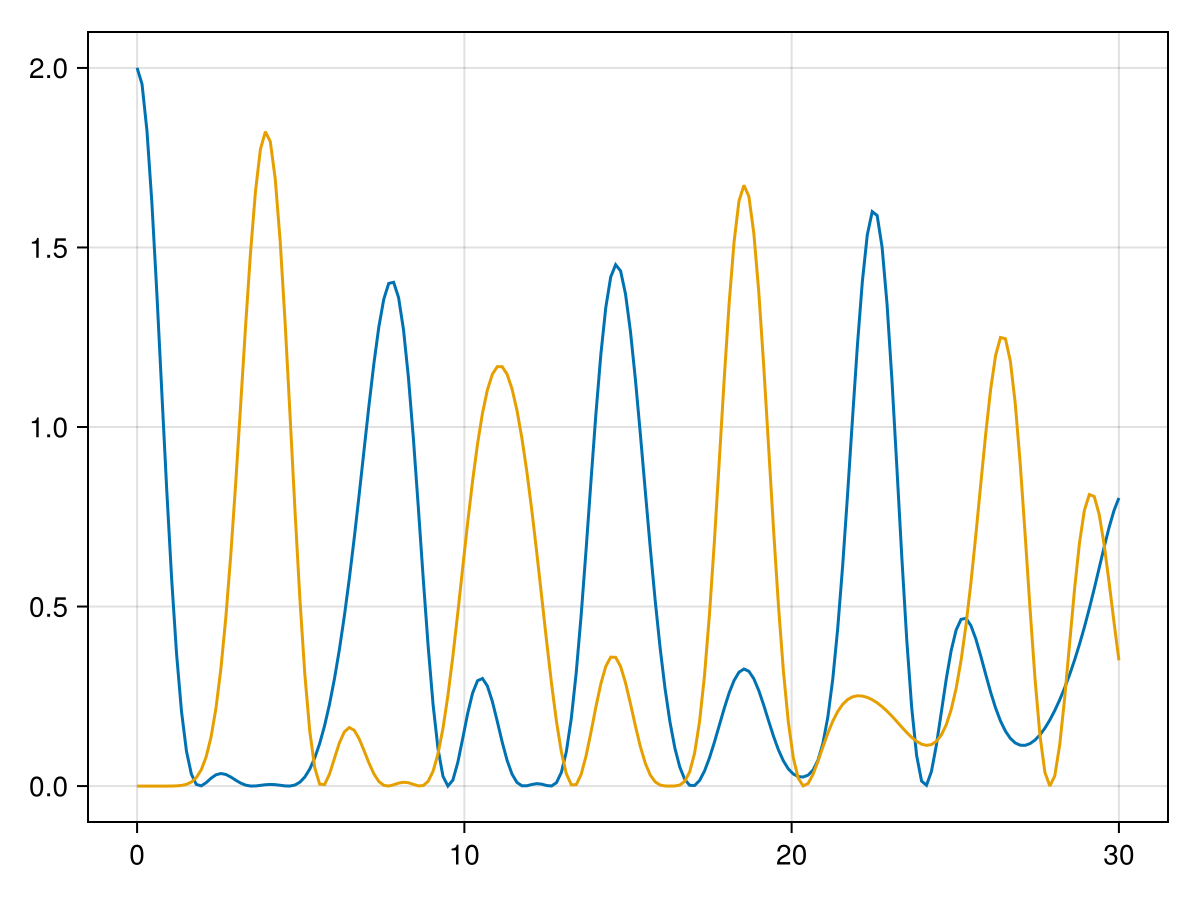

In [10]:
f = Figure()
ax = Axis(f[1, 1])

lines!(tlist, real(result.expect[1,1:end]))
lines!(tlist, real(result.expect[2,1:end]))

f

# Closed MPS 

In [11]:
function entangement_S(ψ, b)
    # b: index where we do the bipartition
    psi = orthogonalize(ψ, b)
    # do the SVM
    U,S,V = svd(psi[b], (linkinds(psi, b-1)..., siteinds(psi, b)...))
    SvN = 0.0
    # Geth the schmidt coefficients
    for n=1:dim(S, 1)
        p = S[n,n]^2
        SvN -= p * log(p)
    end
    return SvN
end

function main_TN(L, J, Δτ, ttotal, cutoff=1E-8  )
    # bettwe to put it in a function to avoid the global julia scope
    """ L = chain size
    J = Hopping
    Δτ = timestep
    ttotal = final time
    cutoff = truncation cutoff"""

    occupations = []
    times = []
    entropies = []
    #  build site indices
    s = siteinds("Boson", L; dim=3, conserve_qns=true)
    # build the time evol gates for TEBD
    gates = ITensor[]
    for j in 1:(L-1)
        s1 = s[j]
        s2 = s[j+1] 
        hj = op("adag",s1)*op("a",s2) + op("adag",s2)*op("a",s1)
        # troterized gate
        Gj = exp(-im * Δτ/2 * hj)
        push!(gates, Gj)

    end
    # The reverse gates for second order accuracy
    append!(gates, reverse(gates))
    # put a particle in the first site
    state_list = ["0" for n in 1:L]
    state_list[1] = "2"
    psi = MPS(s, state_list)

    for t in 0.0:Δτ:ttotal

        # keep track of the occupations at each time step
        occ = ITensorMPS.expect(psi,"N")
        # entanglement entropy between two equal sized parts of the chain
        Svn = entangement_S(psi, Integer(L/2))
        push!(occupations, occ)
        push!(times, t)
        push!(entropies, Svn)

        t≈ttotal && break

        psi = apply(gates, psi; cutoff)
        normalize!(psi)
    end
    return occupations, times, entropies
end


main_TN (generic function with 2 methods)

In [12]:
Occupations, times, Svns = main_TN(L+10, J,tlist[2]-tlist[1], maxt+20);
Occupations = reduce(hcat, Occupations)


16×332 Matrix{Float64}:
 2.0  1.95514      1.82556     1.62546     …  0.369605     0.348402
 0.0  0.0446028    0.170476    0.355352       0.00620938   0.0241856
 0.0  0.000252907  0.00391111  0.0187026      0.00204946   0.0186484
 0.0  1.4424e-6    5.03285e-5  0.00048081     0.217526     0.254672
 0.0  0.0          3.92439e-7  7.86663e-6     0.116495     0.119447
 0.0  0.0          0.0         6.71434e-8  …  0.252563     0.275865
 0.0  0.0          0.0         0.0            0.262881     0.224261
 0.0  0.0          0.0         0.0            0.0723058    0.0584978
 0.0  0.0          0.0         0.0            0.122316     0.0781698
 0.0  0.0          0.0         0.0            0.033318     0.0542619
 0.0  0.0          0.0         0.0         …  0.000337072  0.000321342
 0.0  0.0          0.0         0.0            0.0350191    0.0495572
 0.0  0.0          0.0         0.0            0.0792563    0.0498359
 0.0  0.0          0.0         0.0            0.0430229    0.0232351
 0.0  0.0    

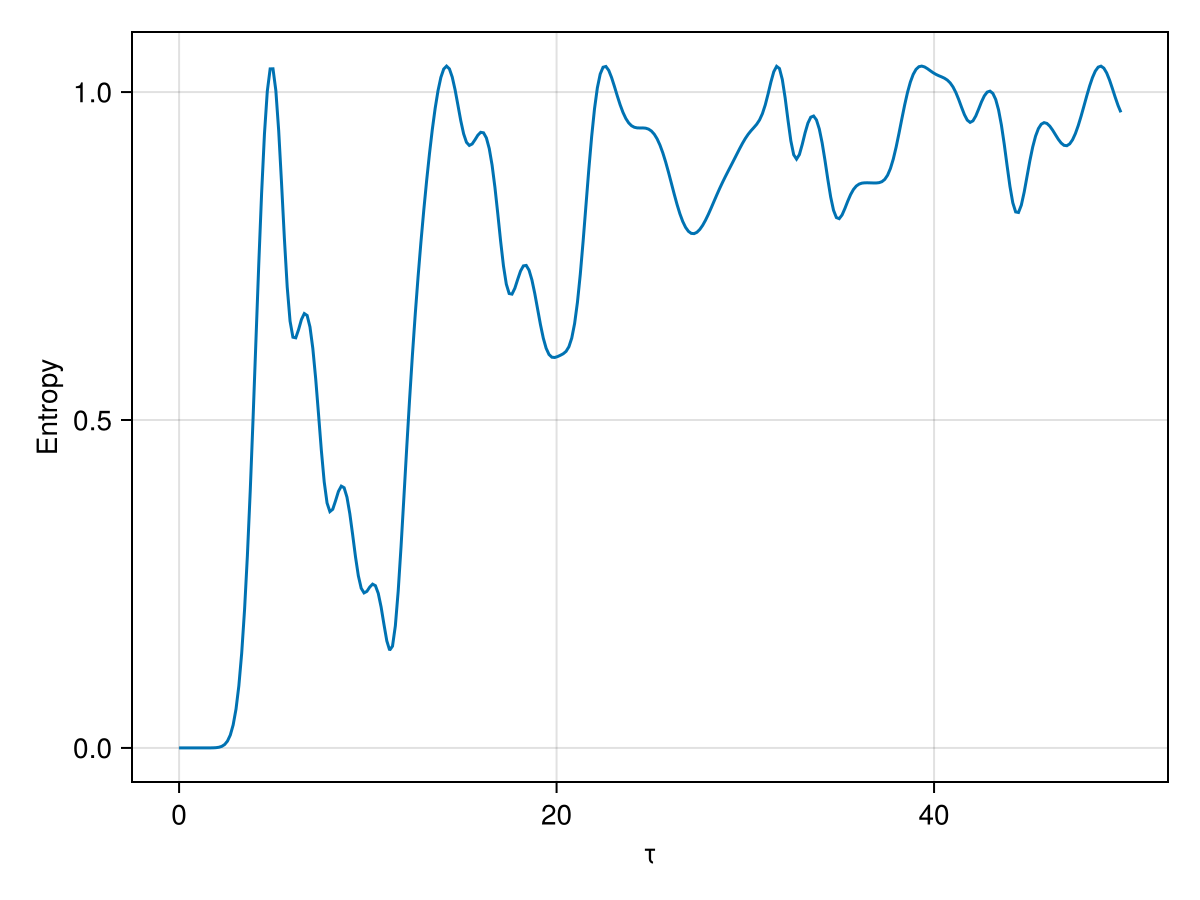

In [13]:
f = Figure()
ax = Axis(f[1, 1], xlabel="τ", ylabel="Entropy")

lines!(times, Svns)
f

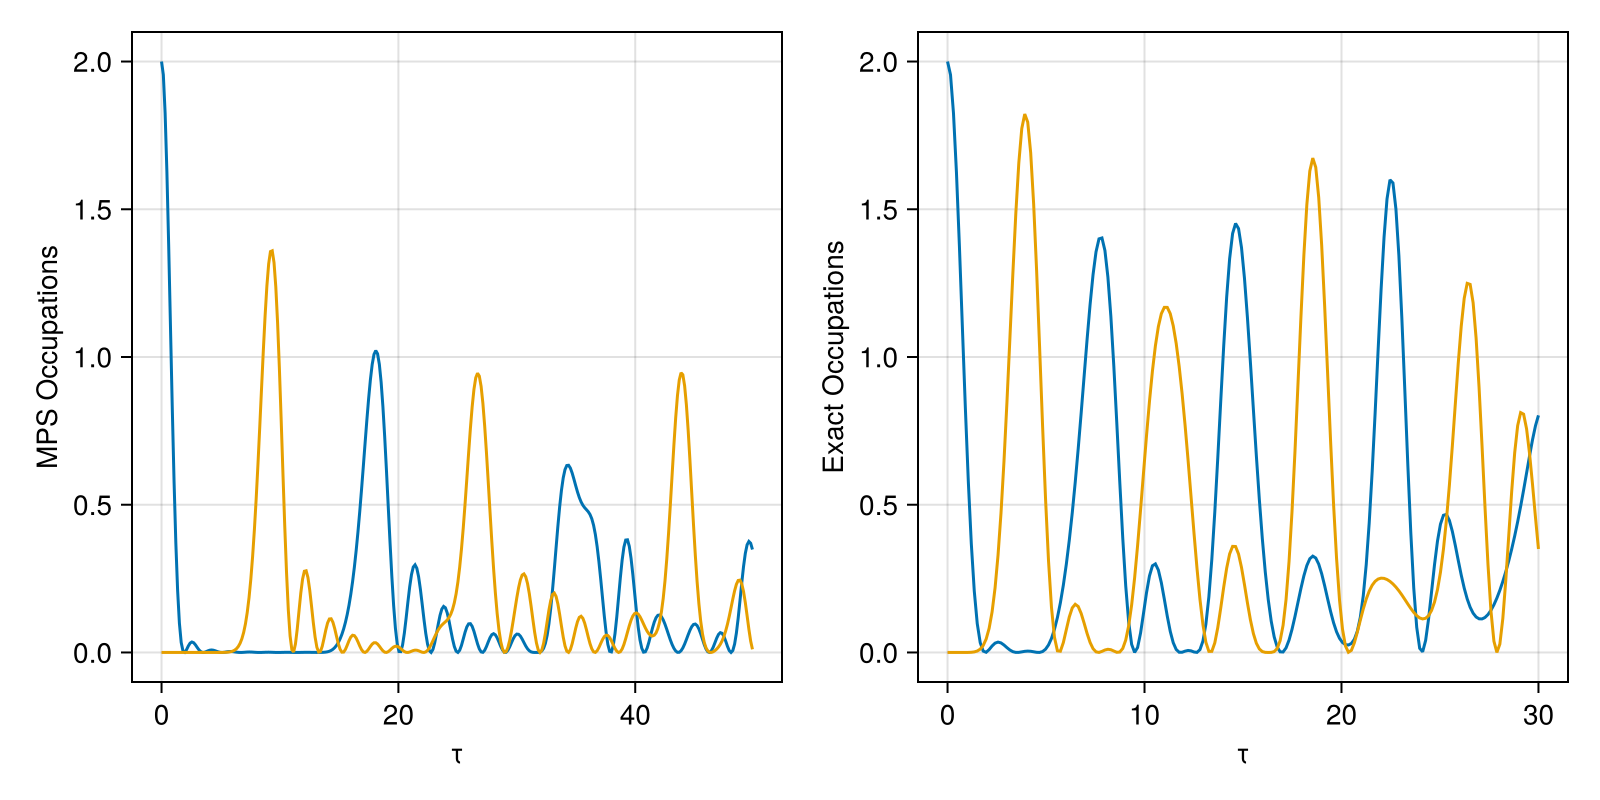

In [14]:
f = Figure(size = (800, 400))
ax1 = Axis(f[1, 1],xlabel="τ", ylabel="MPS Occupations")
ax2 = Axis(f[1, 2],xlabel="τ", ylabel="Exact Occupations")

lines!(ax1, times, Occupations[1,1:end])
lines!(ax1, times, Occupations[end,1:end])

lines!(ax2, tlist, real(result.expect[1,1:end]))
lines!(ax2, tlist, real(result.expect[2,1:end]))
f


# Lindbladian MPS